In [1]:
from runner import *

plotpath = parent_directory + "\\plots\\"
plotting.set_dir(plotpath)

loading complete, calculating accuracy
getting human labeled boundaries
complete


In [2]:
import sys
sys.path.insert(1, 'C:\\Users\\Harrison\\Documents\\GitHub\\FISHFactor\\src')
sys.path.insert(1, 'C:\\Users\\Harrison\\Documents\\GitHub\\FISHFactor')

import torch
import fishfactor
import pyro
import utils as fishutils
import matplotlib

## manage data

### use 25 most prevalent dendrite and soma genes

In [3]:
data = RNA.copy()

## take data in region of interest
# data = data.loc[(RNA['global_y'] > bbox_ymin) & (RNA['global_y'] < bbox_ymax) &
#                    (RNA['global_x'] > bbox_xmin) & (RNA['global_x'] < bbox_xmax)]

data = data.drop(columns=['x', 'y'])

# take data with cell label
data = data.loc[data['cell_index'] > 0]

# find frequent dendrite and soma genes
freq_dendrite = data.loc[data['process_index'] > 0]['barcode_id'].value_counts().index[:25]
freq_soma = data.loc[data['process_index'] == 0]['barcode_id'].value_counts().index[:25]

# take only most frequent dendrite and soma genes
data = data[data['barcode_id'].isin(freq_dendrite.append(freq_soma))]

# rename for fishfactor
data = data.rename(columns={'global_x' : 'x',
                            'global_y' : 'y',
                            'barcode_id' : 'feature',
                            'cell_index' : 'group'})

all_data = data.copy()
process_data = data.loc[data['process_index'] > 0].copy()
soma_data = data.loc[data['process_index'] == 0].copy()

## following FISHFactor's "example.ipynb"

In [4]:
device = 'cuda:0'

model = fishfactor.FISHFactor(
    data=all_data,
    n_latents=3,
    nu=1.5,
    n_inducing=100,
    grid_resolution=50,
    min_density=0.1,
    masks=None,
    normalize_coordinates=True,
    device=device
).to(device=device)


C:\Users\Harrison\anaconda3\envs\Segmentation\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
results = model.inference(
    lr=5e-3,
    lrd=0.5**(1 / 2000),
    n_particles=3,
    max_epochs=20000,
    patience=3000,
    delta=0.01,
    save_every=None,
    save_dir=None,
    max_points=10000,
    print_every=500,
)

C:\Users\Harrison\anaconda3\envs\Segmentation\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


epoch: 0, loss: -0.0106, min loss: [100000.0, 100000.0, 100000.0, 100000.0], patience: 3000


RuntimeError: CUDA out of memory. Tried to allocate 482.00 MiB (GPU 0; 6.00 GiB total capacity; 3.42 GiB already allocated; 473.12 MiB free; 3.91 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

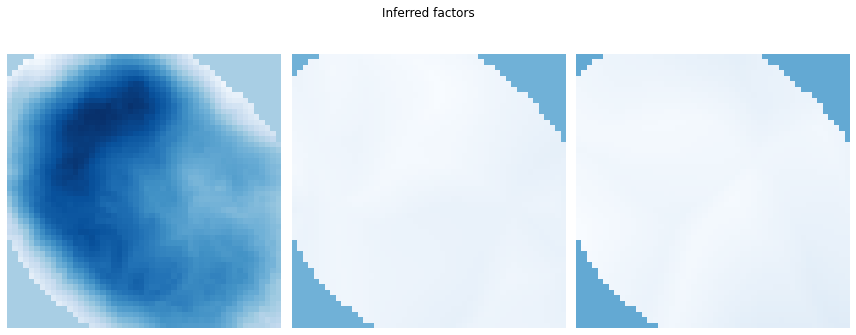

In [18]:
# index between 0 and 14
evaluation_cell = 2

z = fishutils.gp_percentiles(
    model=model.gp_list[evaluation_cell],
    coords=model.grid,
    percentiles=[0.5],
    n_samples=10,
)[0].detach().cpu()

mask = model.masks[evaluation_cell].cpu()

fig, axs = plt.subplots(1, z.shape[0], figsize=(4 * z.shape[0], 5))
fig.suptitle('Inferred factors')

for i, ax in enumerate(axs.flatten()):
    ax.matshow(z[i].view(model.grid_resolution, model.grid_resolution) * mask, origin='lower', cmap='Blues', vmax=z.max())
    ax.axis('off')

plt.tight_layout()